In [1]:
import math
import os
import random

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ot import emd2
from pyxdameraulevenshtein import damerau_levenshtein_distance

from sklearn.cluster import AffinityPropagation, DBSCAN, SpectralClustering
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline
cmap = sns.light_palette('azure', input='xkcd')

In [3]:
def floyd(mt):
    res = mt.copy()
    n = len(mt)
    for i in range(n):
        for k in range(n):
            if i == k: continue
            for j in range(n):
                if i == j or j == k: continue
                if res[i, j] > res[i, k] + res[k, j]:
                    res[i, j] = res[i, k] + res[k, j]
    return res

def get_curvature(mt):
    n = len(mt)
    hop = floyd(np.vectorize(lambda x: n + 1 if x == 0 else 1)(mt))
    for i in range(n):
        hop[i, i] = 0
    piles = [[w / row.sum() for w in row] for row in mt]
    res = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(n):
            if hop[i, j] != 0:
                res[i, j] = 1 - emd2(piles[i], piles[j], hop) / hop[i, j]
    return res

def upper_triangle(mt):
    res = []
    for i in range(mt.shape[0]):
        for j in range(i + 1, mt.shape[1]):
            res.append(mt[i, j])
    return np.array(res)

def levenshtein(a, b):
    return damerau_levenshtein_distance(list(a), list(b))

def show_accuracy(y_test, y_pred):
    print('Точность: ', round(accuracy_score(y_test, y_pred), 3))
    conf_mt = confusion_matrix(y_test, y_pred)
    labels = ['CTL', 'PNT']
    ax = plt.subplot()
    sns.heatmap(conf_mt, annot=True, ax=ax, cmap=cmap)
    ax.set_xlabel('Предсказание')
    ax.set_ylabel('На самом деле')
    ax.set_title('Ошибки')
    ax.xaxis.set_ticklabels(labels) 
    ax.yaxis.set_ticklabels(labels, rotation=360)
    plt.show()

In [4]:
vertex_curvature = []
edge_curvature = []
y = []

for i, (a, b) in enumerate([('controls', 'ctrl'), ('patients', 'pat')]):
    dirname = 'Alzheimer/AD_'+a+'_corr_mats/'
    n = len(os.listdir(dirname))
    curvature = [get_curvature(np.load(dirname+b+'_'+str(j)+'.npy')) for j in range(n)]

    vertex_curvature.append([c.mean(axis=1) for c in curvature])
    edge_curvature.append([upper_triangle(c) for c in curvature])
    y.append([i] * n)

vertex_curvature = np.concatenate(vertex_curvature)
edge_curvature = np.concatenate(edge_curvature)
y = np.concatenate(y)

# Кластеризация по кривизне графа

In [43]:
X = np.array([c.mean() for c in vertex_curvature])

Сначала покажем, что ничего не получится, а потом все же попытаемся классифицировать. Ниже на каждой из прямых отмечены кривизны коннектомов пациентов (красные точки) и контрольной группы (синие точки). Как мы видим, эти множества ощутимо пересекаются.

In [6]:
fig = plt.figure(figsize=(15, 0.5))
ax = plt.subplot()
ax.scatter(X, y, c=['r' if yy == 0 else 'b' for yy in y], s=10)
ax.set_ylim([-1, 2])
ax.set_yticks([])
sns.despine(ax=ax, left=True, right=True, top=True)
fig.add_subplot(ax)
sns.despine(fig=fig, left=True, right=True, top=True)
# fig.savefig('mean.png', bbox_inches='tight', edgecolor='b')

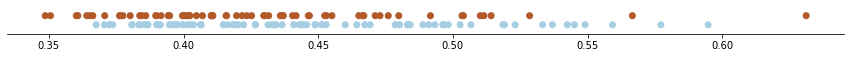

In [7]:
plt.scatter(X, y, c=y, cmap=plt.cm.Paired)
plt.show()

А теперь всё же поклассифицируем. Возьмём среднюю кривизну у контрольной группы и у пациентов.
К какому из средних ближе новая кривизна &mdash; к тому классу и отнесём коннектом.

Точность:  0.581


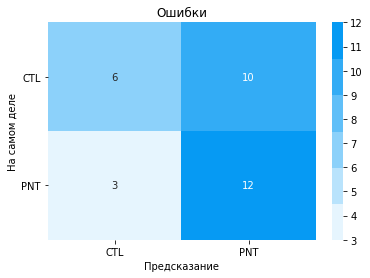

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

cc = X_train[np.where(y_train == 0)[0]].mean()
pc = X_train[np.where(y_train == 1)[0]].mean()

y_pred = [0 if abs(cc - x) < abs(pc - x) else 1 for x in X_test]

show_accuracy(y_test, y_pred)

# Кластеризация по гистограмме

In [9]:
eps = 0.05
X = []
for x in [edge_curvature, vertex_curvature]:
    m = x.min()
    M = x.max()
    b = int(math.ceil((M - m) / eps))
    X.append([np.histogram(c, bins=b, range=(m, M))[0] for c in x])
X = np.concatenate(X, axis=1)

In [10]:
def distance(a, b):
    return damerau_levenshtein_distance(list(a), list(b))
D = np.array([[distance(a, b) for b in X] for a in X])

Сначала посмотрим на граф расстояний. Вершины &mdash; гистограммы коннектомов, цвета &mdash; класс (болен / здоров). Расстояние на рисунке строится в соответствии с матрицей расстояний (т.е. с расстоянием Левенштейна).

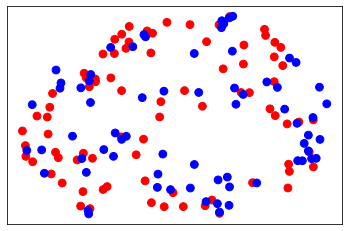

In [41]:
G = nx.from_numpy_array(D)
nx.draw_networkx(
    G, pos=nx.spring_layout(G, weight='weight'), with_labels=False, edgelist=[],
    node_color=['r' if yy == 0 else 'b' for yy in y],
    node_size=60
)
plt.show()

## Наивный классификатор

Будем считать, что пациент болен, если среднее расстояние Левенштейна его гистограммы до кластера с больными меньше, чем до кластера со здоровыми. Получаем точность предсказания от 50 до 66 %:

Точность:  0.609


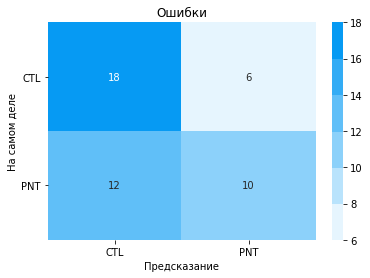

In [32]:
train_i, test_i = train_test_split(np.array(list(range(len(X)))), test_size=0.3)

controls = train_i[np.where(y[train_i] == 0)[0]]
patients = train_i[np.where(y[train_i] == 1)[0]]

y_pred = []
for i in test_i:
    control_dist = np.array([ D[i, j] for j in controls ]).mean()
    patient_dist = np.array([ D[i, j] for j in patients ]).mean()
    y_pred.append(int(patient_dist < control_dist))

show_accuracy(y[test_i], y_pred)

## Другие классификаторы

Как мы видели, классификация на 2 кластера не сработает. Будем разбивать на большее число кластеров, а потом отобразим их на нашу пару "контроль / пациент" следующим образом: для каждого кластера найдём, какого типа элементов больше, и к этому типу отнесём весь кластер.

In [33]:
def group_labels(labels, groups):
    if (min(len(groups), len(labels)) == 0):
        return np.array([])
    bins = np.array([[0 for j in range(max(groups) + 1)] for i in range(max(labels) + 1)])
    for group, label in zip(groups, labels):
        bins[label, group] += 1
    return np.argmax(bins, axis=1)

Точность:  0.649


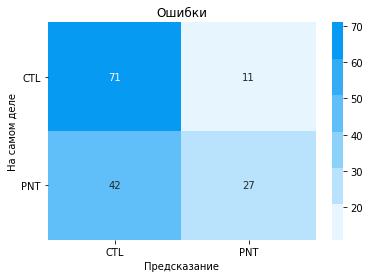

In [68]:
labels = AffinityPropagation(affinity='precomputed', random_state=None).fit_predict(-D)
show_accuracy(y, group_labels(labels, y)[labels])

Точность:  0.616


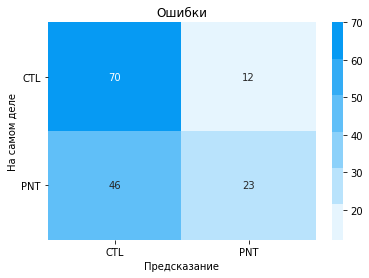

In [74]:
delta = 10
affinity = np.exp(- D ** 2 / (2. * delta ** 2))
labels = SpectralClustering(n_clusters=15, affinity='precomputed').fit_predict(affinity)
show_accuracy(y, group_labels(labels, y)[labels])

Шумы: 0.3708609271523179
Кластеров: 1
Точность:  0.547


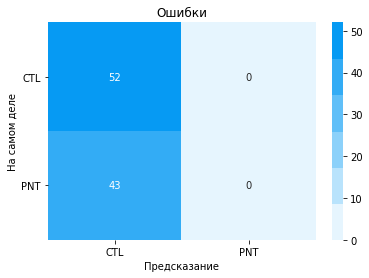

In [38]:
def dbscan(D, k):
    eps = np.partition(D, k, axis=1)[:,k].mean()
    labels = DBSCAN(eps=eps, min_samples=k, metric='precomputed').fit_predict(D)
    clean_y = y[labels != -1]
    clean_labels = labels[labels != -1]
    noise = sum(labels == -1) / len(labels)
    print('Шумы:', noise)
    print('Кластеров:', max(labels) + 1)
    if noise < 1:
        show_accuracy(clean_y, group_labels(clean_labels, clean_y)[clean_labels])
dbscan(D, 5)

Забавный баг: если испортить матрицу расстояний, точность подскочит до 65%
(раньше было аж 99%, но ~50 кластеров, не воспроизводится)

Шумы: 0.2052980132450331
Кластеров: 25
Точность:  0.858


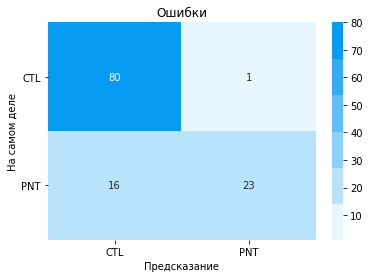

In [17]:
k = 5
dbscan(np.partition(D, k, axis=1), k)